In [14]:
import pandas as pd
import numpy as np
import seaborn as sns; sns.set(font_scale=2.3)
import matplotlib.pyplot as plt
import sklearn
import statsmodels.api as sm
import math
from sklearn.model_selection import train_test_split
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
import xgboost as xgb
%matplotlib inline

In [15]:
import warnings
warnings.filterwarnings('ignore')

In [16]:
%store -r data_new

In [17]:
col = data_new.columns.tolist()
na_count = data_new.isnull().sum()
col_null = na_count.index[na_count.values>0]
data_new[col_null] = data_new[col_null].fillna(0)

In [18]:
data_new_90 = data_new.ix[(data_new['Total_Price'] >=30) & (data_new['Total_Price'] <=300), :-2].copy()
X = data_new_90.ix[:, 1:]
y = data_new_90.ix[:, 0]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 123)
X_train = X_train.reset_index(drop= True)
y_train = y_train.reset_index(drop= True)
X_test = X_test.reset_index(drop= True)
y_test = y_test.reset_index(drop= True)

In [19]:
def RMSPE(y, y_pred):
    return math.sqrt( ((1- y_pred / y)**2).mean() )

In [20]:
data_new_90.shape

(38541, 72)

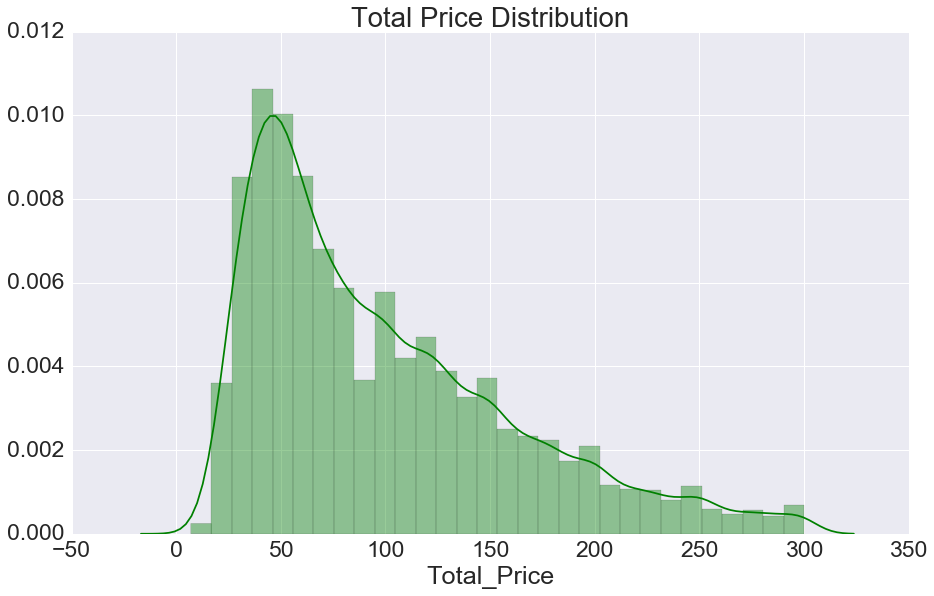

In [13]:
data_plt = data_new.ix[data_new['Total_Price'] <=300, :-2].copy()
plt.figure(figsize = (15, 9))
sns.distplot(data_plt['Total_Price'],bins = 30, color = 'g',  kde= True)
plt.title('Total Price Distribution')
plt.savefig('eda0.jpg')

In [12]:
plt.savefig('eda0.jpg')

## Baseline Model

In [8]:
data_new_90_bl = data_new.ix[(data_new['Total_Price'] >=30) & (data_new['Total_Price'] <=300), ].copy()
X_bl = data_new_90_bl.ix[:, 1:]
y_bl = data_new_90_bl.ix[:, 0]
X_train_bl, X_test_bl, y_train_bl, y_test_bl = train_test_split(X_bl, y_bl, test_size = 0.2, random_state = 123)

In [11]:
bl_price = pd.concat((X_train_bl, y_train_bl), axis = 1).groupby(
    ['neighbourhood_cleansed', 'room_type'])['Total_Price'].mean().reset_index(drop = False)

X_test = pd.merge(X_test_bl, bl_price, on = ['neighbourhood_cleansed', 'room_type'], how = 'left')
y_test = y_test_bl.reset_index(drop = True)
scores_bl = RMSPE(y_test , X_test['Total_Price'])
scores_bl

0.4682110773465417

In [12]:
from sklearn.model_selection import KFold

In [13]:
kf = KFold(n_splits=10, random_state = 123)

## LinearRegression

In [15]:
from sklearn.linear_model import LinearRegression

In [16]:
%%time
lr = LinearRegression()
scores_lr = []
for train_idx, test_idx in kf.split(X_train.values):
    X_train_val, y_train_val = X_train.values[train_idx], y_train.values[train_idx]
    X_test_val, y_test_val = X_train.values[test_idx], y_train.values[test_idx]
    score =RMSPE(y_test_val , lr.fit(X_train_val, y_train_val).predict(X_test_val))
    scores_lr.append(score)

CPU times: user 2.01 s, sys: 294 ms, total: 2.3 s
Wall time: 1.49 s


In [17]:
scores_lr

[0.40751834376956697,
 0.38720915046805743,
 0.41267480383094984,
 0.3944530482315441,
 0.4284535513713673,
 0.42827803930435226,
 0.4073264143208664,
 0.4249576143398338,
 0.42117981718241243,
 0.4014360504904277]

## Lasso

In [19]:
from sklearn.linear_model import Lasso

In [20]:
%%time
alphas = [0.05, 0.1, 0.3, 1, 2, 3, 5, 10]
scores_lasso = []
kf = KFold(n_splits=10, random_state = 123)

for alpha in alphas:
    lasso = Lasso(alpha)
    for train, val in kf.split(X_train):
        score_cv = []
        y_pred = lasso.fit(X_train.values[train],y_train.values[train]).predict(X_train.values[val])
        score_cv.append(RMSPE(y_train.values[val], y_pred))
        score = np.mean(score_cv)
    scores_lasso.append(score)

CPU times: user 2min 54s, sys: 5.47 s, total: 3min
Wall time: 1min 48s


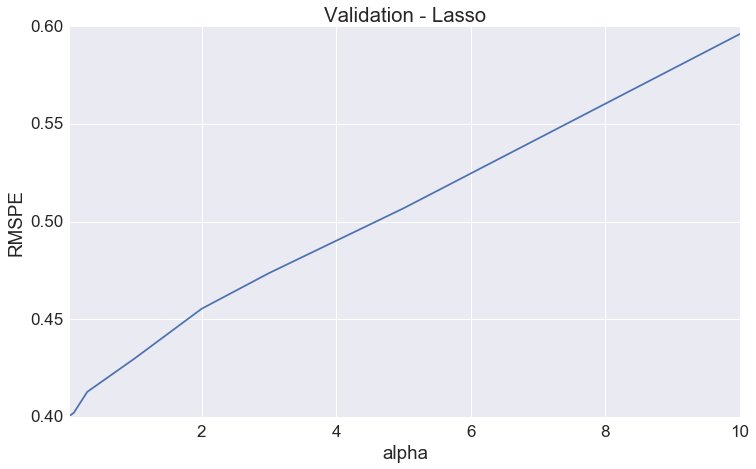

In [21]:
plt.figure(figsize=(12,7))
cv_lasso = pd.Series(scores_lasso, index = alphas)
cv_lasso.plot(title = "Validation - Lasso")
plt.xlabel("alpha")
plt.ylabel("RMSPE")

In [24]:
%%time
alphas = [  0.001, 0.01, 0.02, 0.03, 0.04, 0.05]
scores_lasso = []


for alpha in alphas:
    lasso = Lasso(alpha)
    for train, val in kf.split(X_train):
        score_cv = []
        y_pred = lasso.fit(X_train.values[train],y_train.values[train]).predict(X_train.values[val])
        score_cv.append(RMSPE(y_train.values[val], y_pred))
        score = np.mean(score_cv)
    scores_lasso.append(score)

CPU times: user 5min 59s, sys: 6.85 s, total: 6min 6s
Wall time: 3min 17s


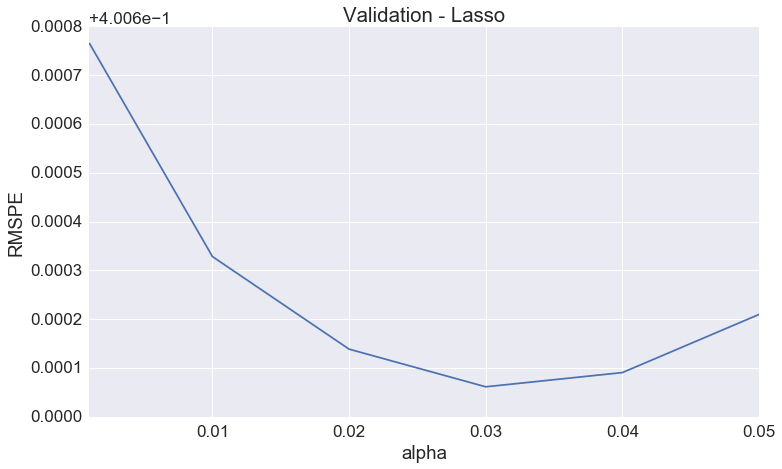

In [25]:
plt.figure(figsize=(12,7))
cv_lasso = pd.Series(scores_lasso, index = alphas)
cv_lasso.plot(title = "Validation - Lasso")
plt.xlabel("alpha")
plt.ylabel("RMSPE")

In [26]:
lasso = Lasso(alpha=0.03)

In [27]:
%%time
scores_lasso = []
kf = KFold(n_splits=10, random_state = 123)
for train, val in kf.split(X_train):
    y_pred = lasso.fit(X_train.values[train],y_train.values[train]).predict(X_train.values[val])
    score = RMSPE(y_train.values[val], y_pred)
    scores_lasso.append(score)

CPU times: user 1min 6s, sys: 1.56 s, total: 1min 7s
Wall time: 39.7 s


In [28]:
scores_lasso

[0.404136373559054,
 0.38501687093359277,
 0.412053179424794,
 0.39241648148897434,
 0.4290290920038769,
 0.42772236844225914,
 0.40595586784921306,
 0.42325781197281415,
 0.42225339123720235,
 0.4006614350293807]

## Bagging

In [30]:
bagging = BaggingRegressor(n_estimators=100, max_samples=1.0, max_features=0.4)

In [31]:
%%time
scores_bagging = []
kf = KFold(n_splits=10, random_state = 123)
for train, val in kf.split(X_train):
    y_pred = bagging.fit(X_train.values[train],y_train.values[train]).predict(X_train.values[val])
    score = RMSPE(y_train.values[val], y_pred)
    scores_bagging.append(score)

CPU times: user 1min 55s, sys: 3.32 s, total: 1min 58s
Wall time: 2min


In [32]:
scores_bagging

[0.4305060697317153,
 0.42089796777123817,
 0.43159922368852544,
 0.431941442173976,
 0.45142145894526065,
 0.43188973442359724,
 0.4305361905836807,
 0.457445648576473,
 0.44054155591289396,
 0.4363246451899208]

## RandomForestRegressor

In [33]:
%%time
scores_rfr = []

clf = RandomForestRegressor(n_estimators=50, n_jobs=-1)
for train, val in kf.split(X_train):
    y_pred = clf.fit(X_train.values[train],y_train.values[train]).predict(X_train.values[val])
    score = RMSPE(y_train.values[val], y_pred)
    scores_rfr.append(score)

CPU times: user 3min 27s, sys: 2.25 s, total: 3min 29s
Wall time: 1min 16s


In [34]:
scores_rfr

[0.3802691173809702,
 0.3886030144585381,
 0.40965993118979377,
 0.371602144977405,
 0.4233835566574026,
 0.3951746058380917,
 0.3803908125119656,
 0.4061262912393688,
 0.3950049434804057,
 0.3718449008050217]

## AdaBoostRegressor

In [35]:
abr = AdaBoostRegressor(n_estimators=200, learning_rate=0.05, loss='linear')

In [36]:
%%time
scores_abr = []
for train, val in kf.split(X_train):
    y_pred = abr.fit(X_train.values[train],y_train.values[train]).predict(X_train.values[val])
    score = RMSPE(y_train.values[val], y_pred)
    scores_abr.append(score)

CPU times: user 3min 18s, sys: 3.64 s, total: 3min 21s
Wall time: 3min 22s


In [37]:
scores_abr

[0.5720508293564982,
 0.5768309375313329,
 0.588447560756691,
 0.5806992698521094,
 0.6074402238360782,
 0.5778284989857245,
 0.5635656138048143,
 0.5949869407989792,
 0.5934800606625041,
 0.5709887666290007]

## XGBoost

In [38]:
est=xgb.XGBRegressor(colsample_bytree=0.4, gamma=0.045, learning_rate=0.1, max_depth=20,
                     min_child_weight=1.5, n_estimators=100,  
                     reg_alpha=0.65, reg_lambda=0.45, subsample=0.8)

In [39]:
%%time
scores_xgb = []
for train, val in kf.split(X_train):
    y_pred = est.fit(X_train.values[train],y_train.values[train]).predict(X_train.values[val])
    score = RMSPE(y_train.values[val], y_pred)
    scores_xgb.append(score)

CPU times: user 2min 19s, sys: 888 ms, total: 2min 20s
Wall time: 2min 21s


In [40]:
scores_xgb

[0.393105922874738,
 0.38694985222911904,
 0.40691212136612764,
 0.369332523833457,
 0.4072720556583928,
 0.39183821164410526,
 0.3776967774733984,
 0.40752727249042275,
 0.4011128499081938,
 0.3739395403785528]

## Plot Model performance over each iteration

In [46]:
scores_summary = pd.DataFrame({'LinearRegression':scores_lr, 'Lasso':scores_lasso, 'Bagging':scores_bagging,
                              'RandomForest':scores_rfr, 'GrandientBoost':scores_xgb})

In [48]:
scores_summary['BaseLine'] = scores_bl
scores_summary

,Bagging,GrandientBoost,Lasso,LinearRegression,RandomForest,BaseLine
0,0.430506,0.393106,0.404136,0.407518,0.380269,0.468211
1,0.420898,0.386950,0.385017,0.387209,0.388603,0.468211
2,0.431599,0.406912,0.412053,0.412675,0.409660,0.468211
3,0.431941,0.369333,0.392416,0.394453,0.371602,0.468211
4,0.451421,0.407272,0.429029,0.428454,0.423384,0.468211
5,0.431890,0.391838,0.427722,0.428278,0.395175,0.468211
6,0.430536,0.377697,0.405956,0.407326,0.380391,0.468211
7,0.457446,0.407527,0.423258,0.424958,0.406126,0.468211
8,0.440542,0.401113,0.422253,0.421180,0.395005,0.468211
9,0.436325,0.373940,0.400661,0.401436,0.371845,0.468211


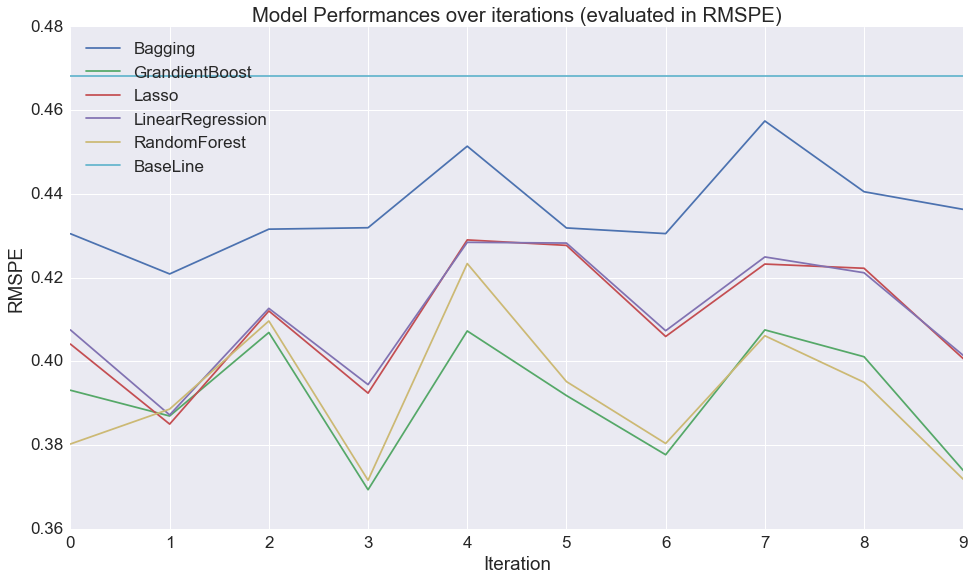

In [63]:
scores_summary.plot(figsize = (16,9))
plt.xlabel('Iteration')
plt.ylabel('RMSPE')
plt.title('Model Performances over iterations (evaluated in RMSPE)')
plt.savefig('BIA652_ModelPerformanceoverIterations.png')

In [52]:
%%time
xgb_params = {"objective": "reg:linear", "eta": 0.01, "max_depth": 10, "seed": 42, "silent": 1,
             'colsample_bytree':0.9, 'gamma':0.3,  'min_child_weight':4,
                     'reg_alpha':0.65, 'reg_lambda':5, 'subsample':0.9}
num_rounds = 1000

dtrain = xgb.DMatrix(X_train, label=y_train)
gbdt = xgb.train(xgb_params, dtrain, num_rounds)

CPU times: user 1min 59s, sys: 575 ms, total: 2min
Wall time: 2min 1s


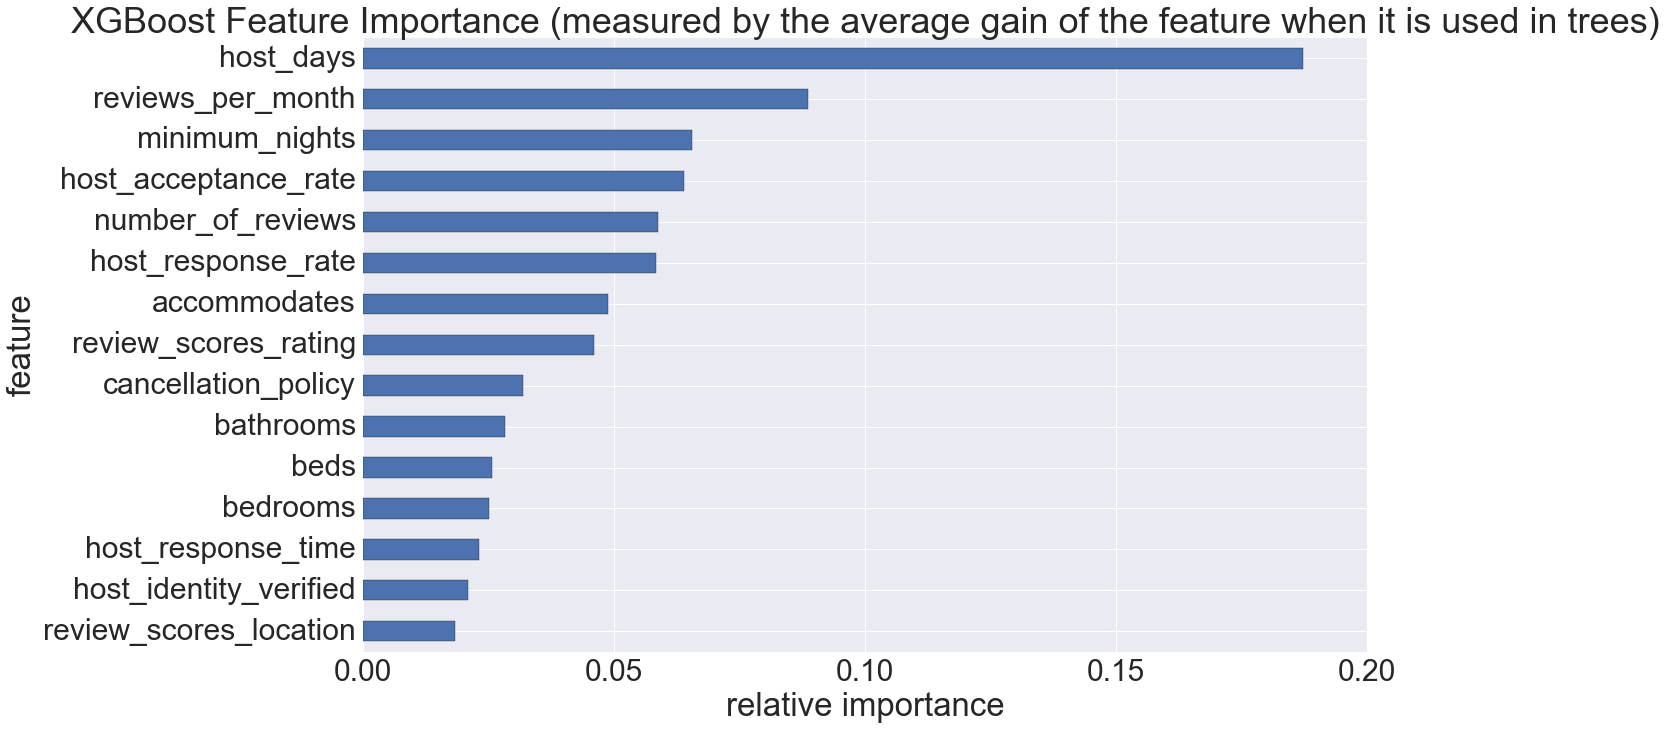

In [73]:
importance = gbdt.get_score(importance_type='weight')
importance = sorted(importance.items(), key = lambda x:x[1], reverse = True)
df = pd.DataFrame(importance, columns=['feature', 'fscore']).sort_values(by = 'fscore')
df['fscore'] = df['fscore'] / df['fscore'].sum()

plt.figure()
df[-15:].plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(18, 11))
plt.title('XGBoost Feature Importance (measured by the average gain of the feature when it is used in trees)')
plt.xlabel('relative importance')
plt.savefig('BIA652_FeatureImportance_weight.png')

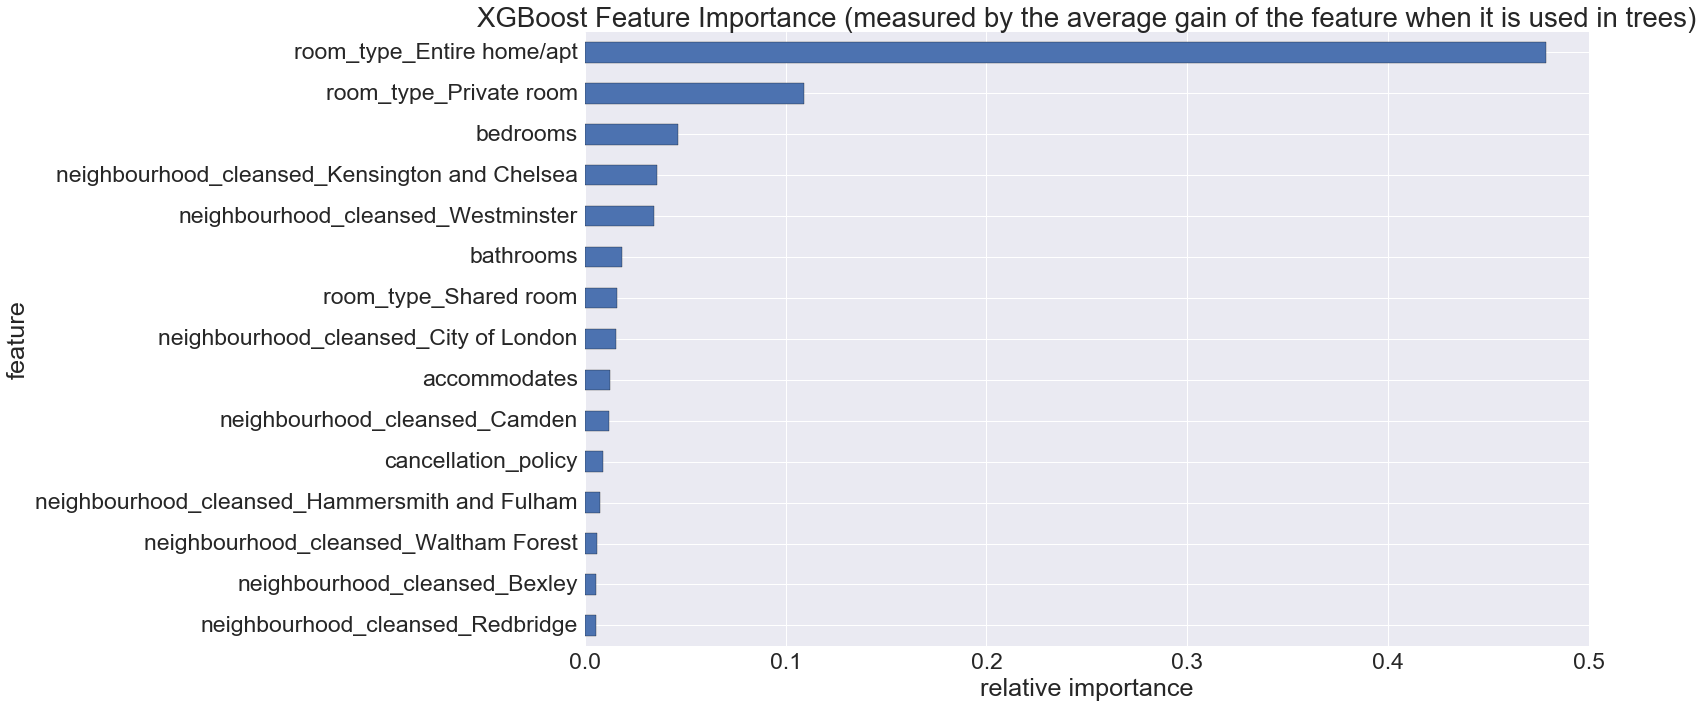

In [76]:
importance = gbdt.get_score(importance_type='gain')
importance = sorted(importance.items(), key = lambda x:x[1], reverse = True)
df = pd.DataFrame(importance, columns=['feature', 'fscore']).sort_values(by = 'fscore')
df['fscore'] = df['fscore'] / df['fscore'].sum()

plt.figure()
df[-15:].plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(18, 11))
plt.title('XGBoost Feature Importance (measured by the average gain of the feature when it is used in trees)')
plt.xlabel('relative importance')
plt.savefig('BIA652_FeatureImportance_gain.png')

In [54]:
data_new_90 = data_new.ix[(data_new['Total_Price'] >=30) & (data_new['Total_Price'] <=300), :-2].copy()
X = data_new_90.ix[:, 1:]
y = data_new_90.ix[:, 0]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 123)
X_train = X_train.reset_index(drop= True)
y_train = y_train.reset_index(drop= True)
X_test = X_test.reset_index(drop= True)
y_test = y_test.reset_index(drop= True)

In [55]:
%%time
est=xgb.XGBRegressor(colsample_bytree=0.9, gamma=0.3, learning_rate=0.01, max_depth=10,
                     min_child_weight=4, n_estimators=1000,  
                     reg_alpha=0.65, reg_lambda=5, subsample=0.9)
y_pred_est = est.fit(X_train,y_train).predict(X_test)


CPU times: user 2min, sys: 443 ms, total: 2min
Wall time: 2min 1s


In [56]:
RMSPE(y_test, y_pred_est)

0.36289876308784536

In [57]:
data_error_xgb = pd.concat((X_test, y_test, pd.DataFrame(y_pred_est)), axis = 1)
col = data_error_xgb.columns.tolist()
col[-1] = 'Total_Price_Pred'
data_error_xgb.columns = col
data_error_xgb['Error'] = data_error_xgb['Total_Price_Pred'] - data_error_xgb['Total_Price']
data_error_xgb['Error_Rate'] = data_error_xgb['Error'] / data_error_xgb['Total_Price']

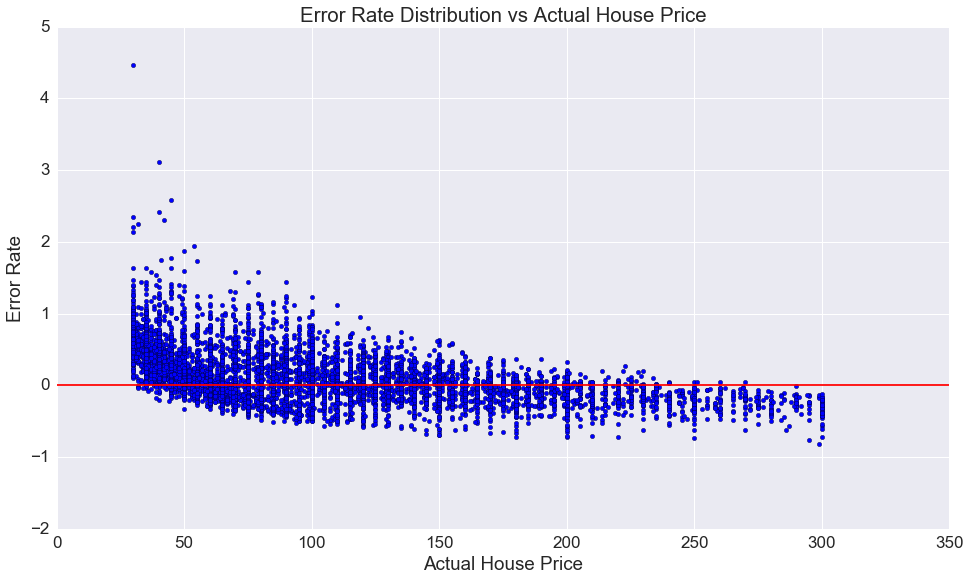

In [68]:
plt.figure(figsize = (16,9))
plt.scatter(data_error_xgb['Total_Price'], data_error_xgb['Error_Rate'])
plt.axhline(y=0, xmin=0, xmax=350,  c = 'r')
plt.title('Error Rate Distribution vs Actual House Price')
plt.xlabel('Actual House Price')
plt.ylabel('Error Rate')
plt.savefig('BIA652_ErrorRateDistributionvsActualPrice.png')

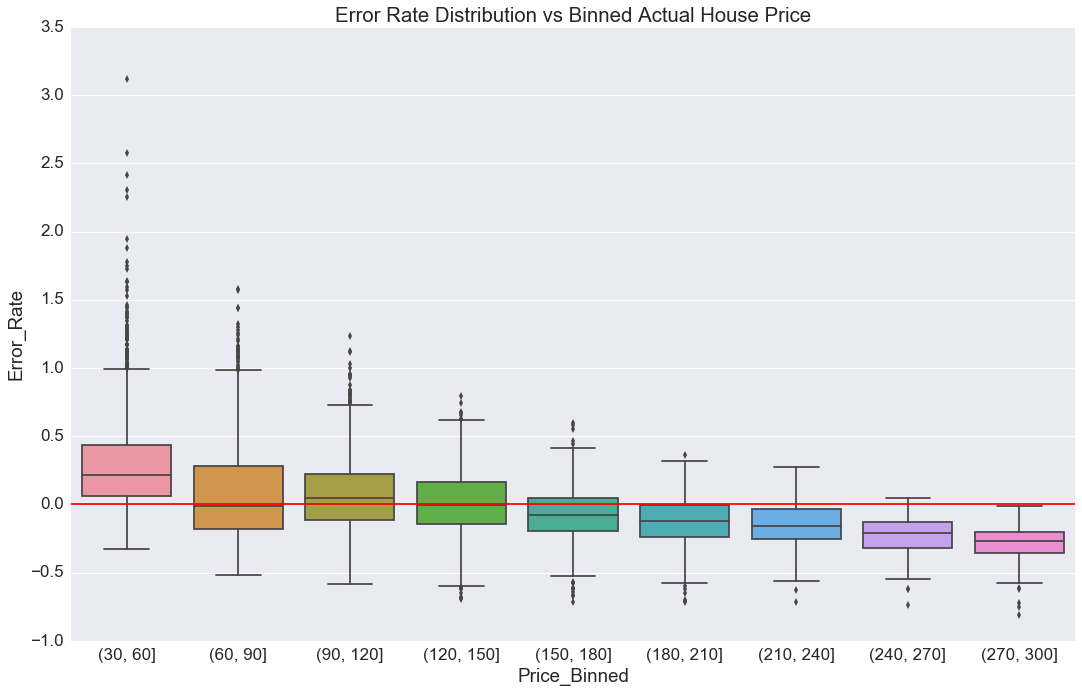

In [69]:
bins = np.linspace(30,300, 10)
data_error_xgb['Price_Binned'] = pd.cut(data_error_xgb['Total_Price'], bins = bins)
plt.figure(figsize = (18,11))
sns.boxplot(x = data_error_xgb['Price_Binned'] , y = data_error_xgb['Error_Rate'] )
plt.title('Error Rate Distribution vs Binned Actual House Price')
plt.axhline(y=0, xmin=0, xmax=350,  c = 'r')
plt.savefig('BIA652_ErrorRateDistributionvsBinnedPrice.png')

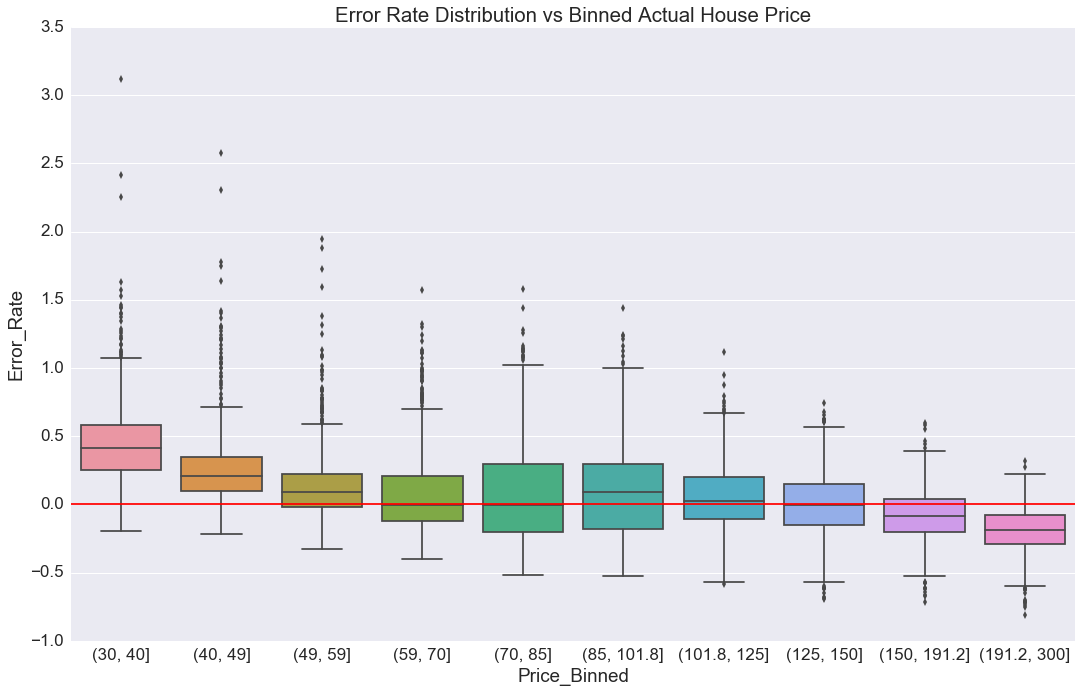

In [70]:
bins_10 = data_error_xgb['Total_Price'].quantile(np.arange(0,1.1,0.1))
data_error_xgb['Price_Binned'] = pd.cut(data_error_xgb['Total_Price'], bins = bins_10)
plt.figure(figsize = (18,11))
sns.boxplot(x = data_error_xgb['Price_Binned'] , y = data_error_xgb['Error_Rate'] )
plt.title('Error Rate Distribution vs Binned Actual House Price')
plt.axhline(y=0, xmin=0, xmax=350,  c = 'r')
plt.savefig('BIA652_ErrorRateDistributionvsBinnedPrice2.png')

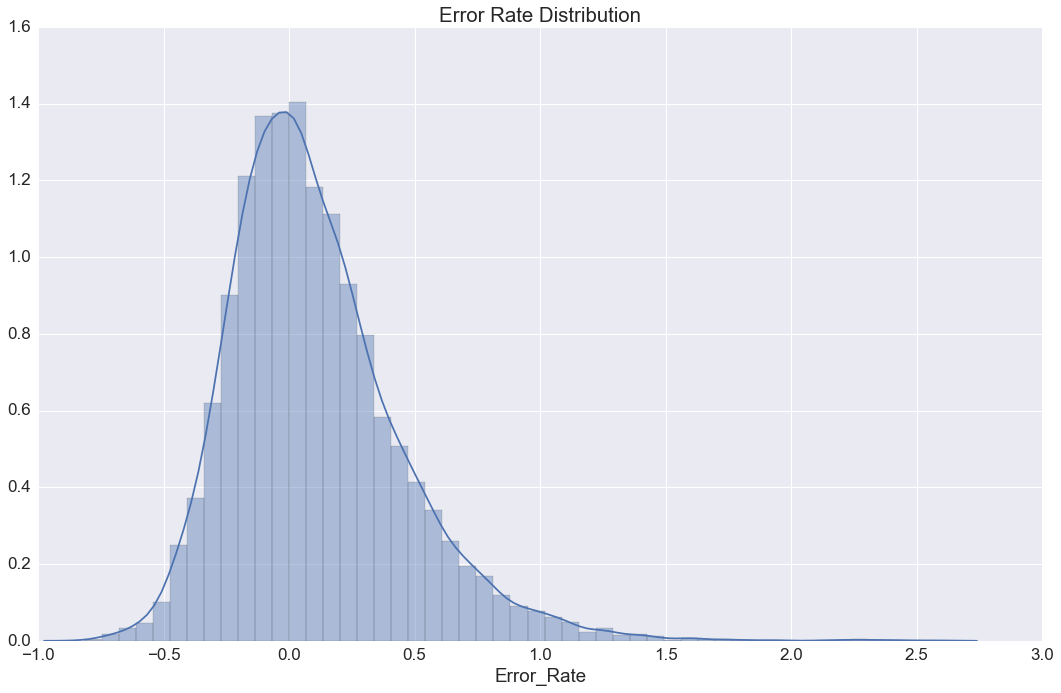

In [71]:
plt.figure(figsize =(18,11) )
sns.distplot(data_error_xgb.ix[data_error_xgb['Error_Rate']<=3,'Error_Rate' ], );
plt.title('Error Rate Distribution')
plt.savefig('BIA652_ErrorRateDistribution.png')